***TWITTER SENTIMENT ANALYYSIS***


*IMPORTS*

In [46]:
import numpy as np
import pandas as pd

#data visulization
import matplotlib.pyplot as plt
import seaborn as sns

#strings and regular expression
import string
import re

#natural language tool kit
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer

#worldcloud
from wordcloud import WordCloud

#sci-kit
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

#flask
from flask import Flask, render_template, request

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/abhinavdeep/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


*LOADING DATASET*

In [47]:
# loading dataset into dataframe form csv file
path = './Dataset/tweets.csv'
data = pd.read_csv(path, encoding = "Latin-1", names = [
    'target', 'uid', 'timestamp', 'flag', 'username', 'tweet'])
print("Tweets loaded successfully!")

Tweets loaded successfully!


*EXPLORATORY DATA ANALYSIS*

In [48]:
#checking data size in rows and column
data.shape

(1600000, 6)

In [49]:
#checking how our data looks
data.head()

,target,uid,timestamp,flag,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [50]:
#describing our data
data.describe()

,target,uid
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [51]:
#checking data-type of each attribute
data.dtypes

target        int64
uid           int64
timestamp    object
flag         object
username     object
tweet        object
dtype: object

In [52]:
#checking values for our target variable
data['target'].unique()

array([0, 4])

In [53]:
#checking for NA value in our data
data.isnull().values.any()

False

In [54]:
#distribution of target value
data['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

Shows our data is balanced

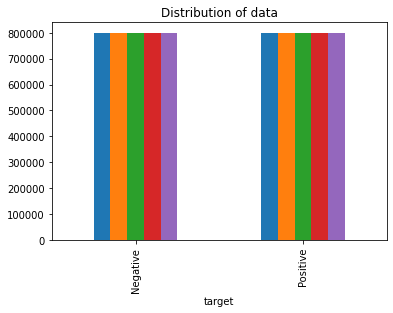

In [55]:
#visualizing data and the distribution of data
ax = data.groupby('target').count().plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['Negative', 'Positive'])
text, sentiment = list(data['tweet']), list(data['target'])

In [56]:
#count of each attribute
ax = data.groupby('target').count()
ax

,uid,timestamp,flag,username,tweet
target,,,,,
0,800000,800000,800000,800000,800000
4,800000,800000,800000,800000,800000


<AxesSubplot:xlabel='target', ylabel='count'>

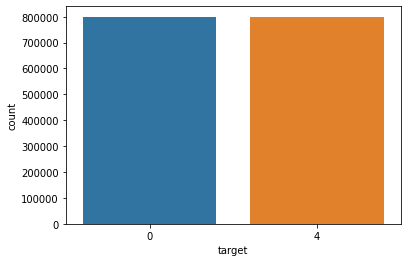

In [57]:
#visualization of target values in our data
sns.countplot(x='target', data = data)

*DATA PREPROCESSING*

In [58]:
#we will use tweet body to predict target value
data = data[['tweet', 'target']]
data

,tweet,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,4
1599996,TheWDB.com - Very cool to hear old Walt interv...,4
1599997,Are you ready for your MoJo Makeover? Ask me f...,4
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4


In [59]:
#setting target value 1 for positive sentiment instead of 4
data['target'] = data['target'].replace(4, 1)
data['target'].unique()

array([0, 1])

In [60]:
#spliting positive and negative sentiment data
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [61]:
#creating dataset with the subset of the entire data
def amt_of_data(num):
    num_data_pos = data_pos.head(num)
    num_data_neg = data_neg.head(num)
    dataset = pd.concat([num_data_neg, num_data_pos])
    print("Dataset created with", num, "target values for both positive and negative sentiments each.")
    return dataset

In [62]:
#converting tweet body in lowercase
def lowering_case(data):
    print("Changing data to lower case...", end = "")
    data['tweet'] = data['tweet'].str.lower()
    print(" done!!")
    return data

In [63]:
#defining stopwords
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', 'thats', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']
STOPWORDS = set(stopwordlist)
STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'by',
 'can',
 'd',
 'did',
 'do',
 'does',
 'doing',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'has',
 'have',
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'it',
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'more',
 'most',
 'my',
 'myself',
 'now',
 'o',
 'of',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'own',
 're',
 's',
 'same',
 'she',
 'shes',
 'should',
 'shouldve',
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 'thatll',
 'thats',
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 'these',
 'they',
 'this',
 'those',
 'through',
 'to',
 'too',
 'under',
 'until',
 'up',
 've',
 'very',
 'was',
 'w

In [64]:
#removing stopwords from data
def removing_stopword(data):
    print("Removing stopwords from data...", end = "")
    def cleaning_stopwords(text):
        return " ".join([word for word in str(text).split() if word not in STOPWORDS])
    data['tweet'] = data['tweet'].apply(lambda x: cleaning_stopwords(x))
    print(" done!!")
    return data

In [65]:
#removing urls
def removing_urls(data):
    print("Removing URLs from data...", end = "")    
    def cleaning_URLs(text):
        return re.sub('((www.[^s]+)|(https?://[^s]+))', '', text)
    data['tweet'] = data['tweet'].apply(lambda x: cleaning_URLs(x))
    print(" done!!")
    return data

In [66]:
#removing profiles mentioned
def removing_mentions(data): 
    print("Removing profiles mentioned in the data...", end = "")       
    def cleaning_mentions(text):
        return re.sub('[@]+\w*', '', text)
    data['tweet'] = data['tweet'].apply(lambda x: cleaning_mentions(x))
    print(" done!!")
    return data

In [67]:
#removing punctuations
def removing_punctuations(data):
    print("Removing puncuations from data...", end = "")
    punctuations_list = string.punctuation
    def cleaning_punctuations(text):
        translator = str.maketrans('', '', punctuations_list)
        return text.translate(translator)
    data['tweet'] = data['tweet'].apply(lambda x: cleaning_punctuations(x))
    print(" done!!")
    return data

In [68]:
#removing repeating characeters
def removing_repeatingchars(data):
    print("Removing repeating characters...", end = "")
    def cleaning_repeating_chars(text):
        return re.sub(r'(.)1+', r'1', text)
    data['tweet'] = data['tweet'].apply(lambda x: cleaning_repeating_chars(x))
    print(" done!!")
    return data

In [69]:
#tokenizing
def tokenizing(data):
    print("Tokenizing data...", end = "")
    tokenizer = RegexpTokenizer('\s+', gaps = True)
    data['tweet'] = data['tweet'].apply(tokenizer.tokenize)
    print(" done!!")
    return data

In [70]:
#lemmatizing
def lemmatizing(data):
    print("Lemmatizing data...", end = "")
    lm = nltk.WordNetLemmatizer()
    def lemmatizer_on_text(data):
        data = [lm.lemmatize(word) for word in data]
        return data
    data['tweet'] = data['tweet'].apply(lambda x: lemmatizer_on_text(x))
    print(" done!!")
    return data

In [71]:
#stemming
def stemming(data):
    print("Stemming data...", end = "")
    st = nltk.PorterStemmer()
    def stemming_on_text(data):
        data = [st.stem(word) for word in data]
        return data
    data['tweet'] = data['tweet'].apply(lambda x: stemming_on_text(x))
    print(" done!!")
    return data

In [72]:
# preparing data to feed our model
dataset = amt_of_data(800000)
def process_data(dataset):
    dataset = lowering_case(dataset)
    dataset = removing_urls(dataset)
    dataset = removing_mentions(dataset)
    dataset = removing_repeatingchars(dataset)
    dataset = removing_punctuations(dataset)
    dataset = removing_stopword(dataset)
    dataset = tokenizing(dataset)
    dataset = lemmatizing(dataset)
    dataset = stemming(dataset)
    print("\nData ready to feed to the model.")
    return dataset
dataset = process_data(dataset)

# preparing raw data to feed our model
def process_data_show_steps(dataset):
    print(dataset)
    dataset = lowering_case(dataset)
    print(dataset)
    dataset = removing_urls(dataset)
    print(dataset)
    dataset = removing_mentions(dataset)
    print(dataset)
    dataset = removing_repeatingchars(dataset)
    print(dataset)
    dataset = removing_punctuations(dataset)
    print(dataset)
    dataset = removing_stopword(dataset)
    print(dataset)
    dataset = tokenizing(dataset)
    print(dataset)
    dataset = lemmatizing(dataset)
    print(dataset)
    dataset = stemming(dataset)
    print(dataset)
    print("\nData ready to feed to the model.")
    return dataset

Dataset created with 800000 target values for both positive and negative sentiments each.
Changing data to lower case... done!!
Removing URLs from data... done!!
Removing profiles mentioned in the data... done!!
Removing repeating characters... done!!
Removing puncuations from data... done!!
Removing stopwords from data... done!!
Tokenizing data... done!!
Lemmatizing data... done!!
Stemming data... done!!

Data ready to feed to the model.


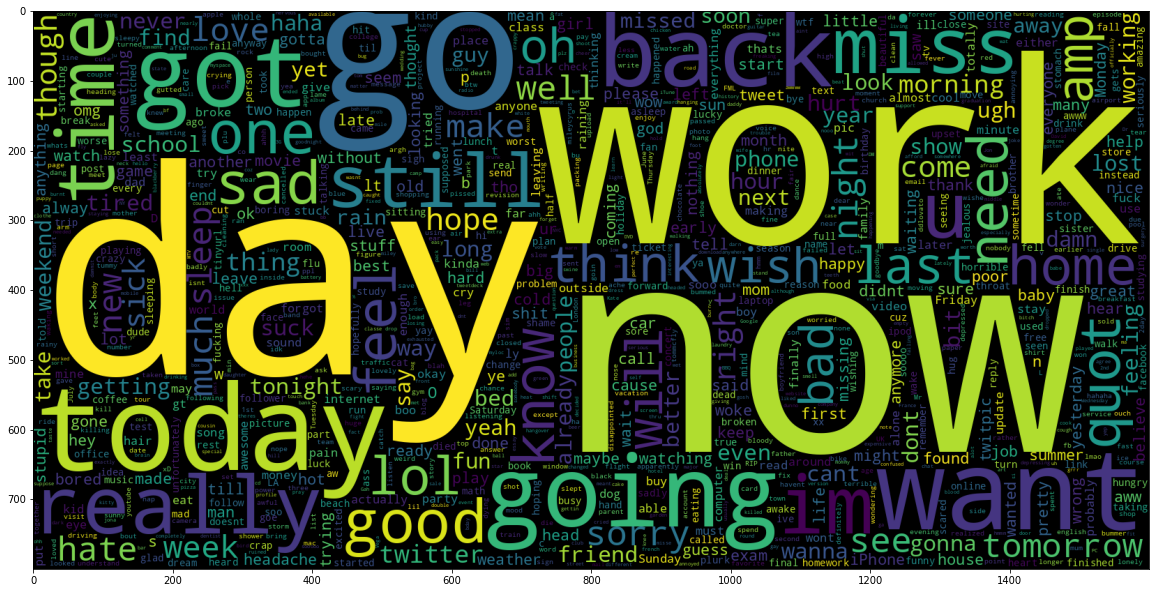

In [73]:
# negative sentiment word cloud
neg = data['tweet'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(neg))
plt.imshow(wc)

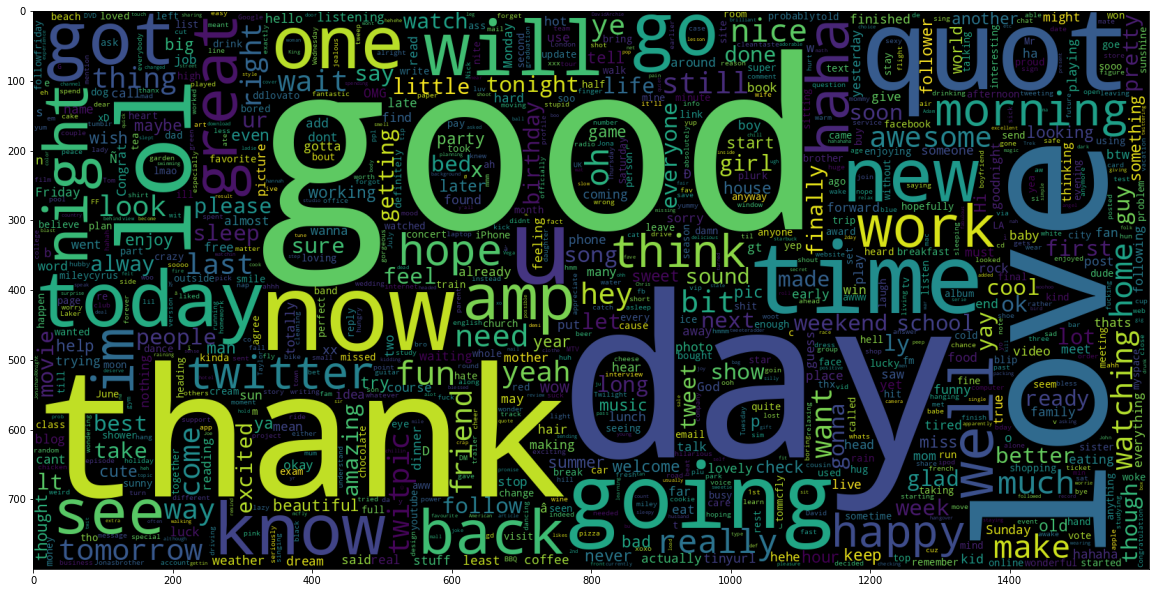

In [74]:
# positive sentiment wordcloud
pos = data['tweet'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

*MODEL TRAINING AND TESTING*

In [75]:
# defining X and y
X = dataset.tweet.astype('str')
y = dataset.target

In [76]:
# spliting data into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [77]:
# using vectorizer
vectoriser = TfidfVectorizer(ngram_range = (1, 2), max_features = 5000000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  3508804


In [78]:
# vectorizing data
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

In [79]:
# creating function to evaluate differnt models
def model_evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.80      0.77      0.78    160156
           1       0.78      0.81      0.79    159844

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



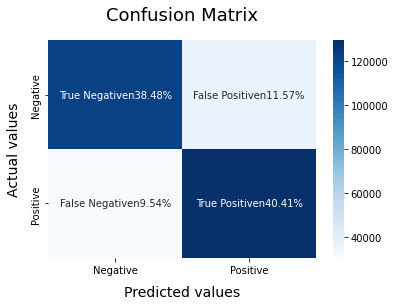

In [80]:
# using Bernoulli's Naive Bayes
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

              precision    recall  f1-score   support

           0       0.80      0.80      0.80    160156
           1       0.80      0.80      0.80    159844

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



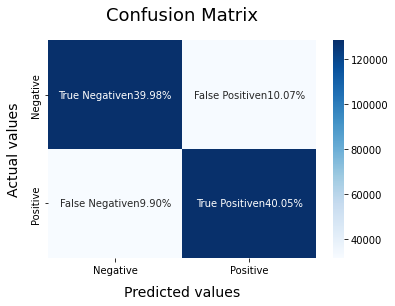

In [81]:
# using Support vector Machine
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81    160156
           1       0.81      0.81      0.81    159844

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



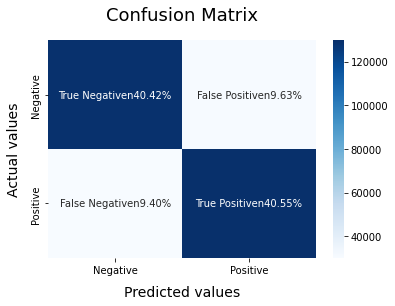

In [82]:
# using Logistic Regression
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

In [83]:
# selecting model with best accuracy
final_model = LRmodel

*DEPLOYING MODEL*

In [85]:
# deploying our model
app = Flask(__name__)
@app.route("/")

def hello():
    return render_template("index.html")

@app.route("/sub", methods = ['POST'])
def result():
    if request.method == "POST":
        tweet = request.form["tweet"]
        raw_data = pd.DataFrame([[tweet]])
        col_names = ['tweet']
        raw_data.columns = col_names
        print(raw_data)
        data = process_data_show_steps(raw_data)
        X = data.tweet.astype(str)
        X = vectoriser.transform(X)
        y = (final_model.predict(X)).astype('str')
        sentiment = "Positive" if y == '1' else "Negative"
        return render_template("result.html", show = sentiment)

if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000 (Press CTRL+C to quit)


**THE END**